In [48]:
import numpy as np
import pandas as pd
import glob
from astropy.table import Table
import matplotlib.pyplot as plt
import json 
import collections
import astropy

In [2]:
sample = Table.read("C:/Users/20xha/Documents/Caltech/Research/superfit/ZTFI_data/sample/SEDM_ML_sample.ascii", format = "ascii")
sample.rename_column('col1', 'ZTF_Name')
sample.rename_column('col2', "Class")
sample.rename_column('col3', "redshift")
sample.rename_column('col8', "Version")

In [27]:
class_new = Table.from_pandas(pd.read_csv(r'thermonuclear-white-dwarf-classifications2.csv'))

In [28]:
classification = class_new[np.where(class_new["workflow_version"] == 98.24)[0]]

In [29]:
classifiers = list(classification["user_name"].data)
unique_names = np.unique(classifiers)
nums = []
for i in unique_names:
    nums.append(classifiers.count(i))
nums = np.asarray(nums)

<BarContainer object of 17 artists>

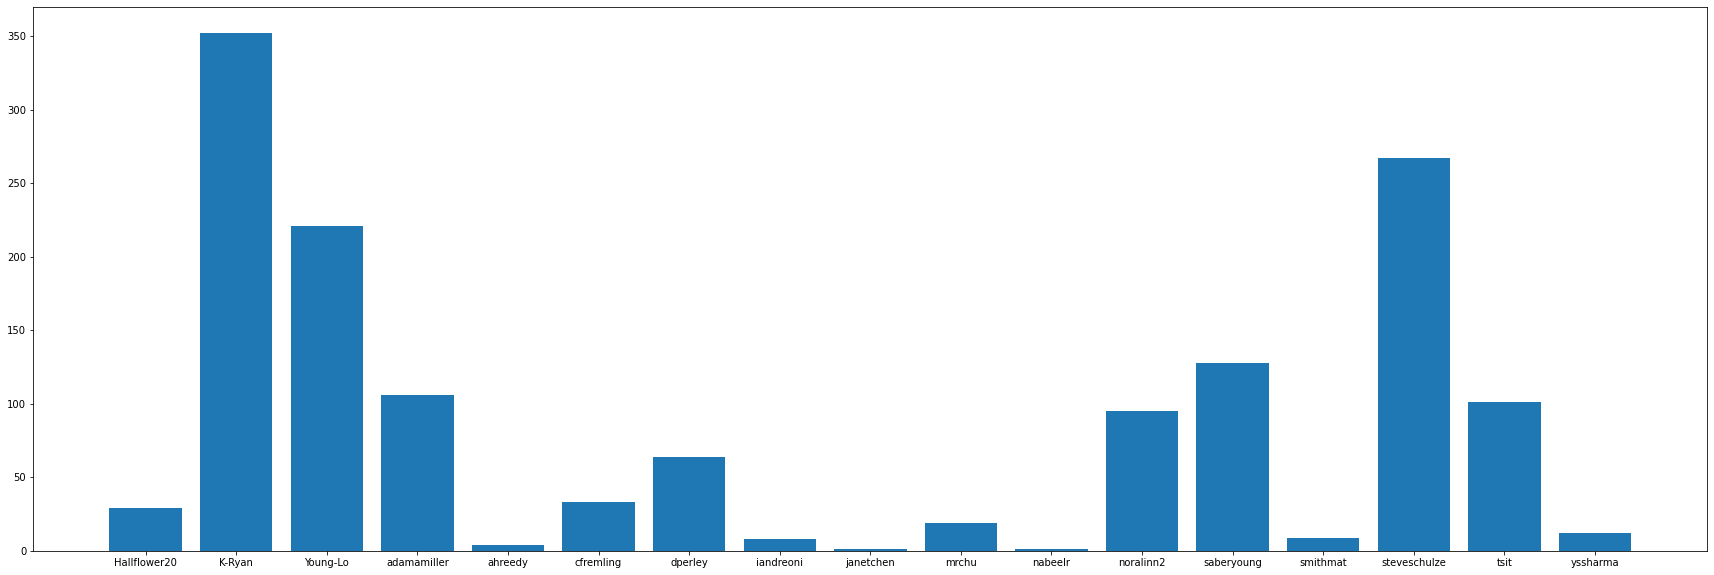

In [30]:
fig = plt.figure(figsize = (30,10))
plt.bar(unique_names, nums)

In [31]:
subject_ids_unique = np.unique(classification["subject_ids"])

data = []
counter = 0
for ids in subject_ids_unique:
    if(counter % 200 == 0):
        print(counter)
    counter += 1
    lines = np.where(classification["subject_ids"] == ids)[0]
    data.append([ids, lines])
    
data_np = np.asarray(data)

0
200
400
600
800
1000


C:\Users\20xha\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [32]:
data_array = []
max_len = 0
for i in data_np:
    if(len(i[1]) > 1):
        if(len(i[1])> max_len):
            max_len = len(i[1])
        data_array.append([i[0], classification[i[1]]])
max_len

2

In [43]:
ResultsTable_Zooniverse = Table(
                    names=("ZTF_Name", "subject_ids", "classifier_1", "classification_1", "best_match_1", "classifier_2", "classification_2", "best_match_2", "classifier_3", "classification_3", "best_match_3",
                           "classifier_4", "classification_4", "best_match_4", "classifier_5", "classification_5", "best_match_5"
                    ),
                    meta={"name": "Spectrum Results after Zooniverse"},
                    dtype=("U64", "int32", "U64", "U64", "U64", "U64", "U64", "U64", "U64", "U64", "U64", "U64", "U64", "U64", "U64", "U64", "U64"
                          )
                    )
for line in data_array:
    row = []
    data = line[1]
    metadata = json.loads(data[0]["subject_data"])[str(line[0])]
    row.append(metadata["ZTF_Name"])
    row.append(line[0])
    for i in data:
        if(i["user_name"] not in row):
            row.append(i["user_name"])
            value = json.loads(i["annotations"])[0]["value"]
            if(value is not None):
                given_type = value[0]["choice"]
                if(given_type == "NOGOODMATCH"):
                    row.extend([given_type, "NA"])
                elif(given_type == "CANNOTBECLASSIFIED"):
                    row.extend([given_type, "NA"])
                else:
                    if(given_type == "NONSNAGNORCVORGALORETC"):
                        given_type = given_type# + "-" + value[0]["answers"]["NOTASNSUBTYPE"]
                    row.append(given_type)
                    row.append(value[0]["answers"]["IFSNIDSUPERFITWHICHIMAGEPROVIDESTHEBESTMATCHMARSHAL999"])
    if(len(row) == 8):
        row.extend(["NA","NA","NA","NA","NA","NA","NA","NA","NA"])
    if(len(row) == 11):
        row.extend(["NA","NA","NA","NA","NA","NA"])
    if(len(row) == 14):
        row.extend(["NA","NA","NA"])
    ResultsTable_Zooniverse.add_row(row)

In [44]:
ResultsTable_Zooniverse

ZTF_Name,subject_ids,classifier_1,classification_1,best_match_1,classifier_2,classification_2,best_match_2,classifier_3,classification_3,best_match_3,classifier_4,classification_4,best_match_4,classifier_5,classification_5,best_match_5
str64,int32,str64,str64,str64,str64,str64,str64,str64,str64,str64,str64,str64,str64,str64,str64,str64
ZTF18abokhip,68677455,steveschulze,CANNOTBECLASSIFIED,NA,dperley,NONSNAGNORCVORGALORETC,999,NA,NA,NA,NA,NA,NA,NA,NA,NA
ZTF18abquyqj,68677461,ahreedy,SNIANORM,1,K-Ryan,SNIANORM,3,NA,NA,NA,NA,NA,NA,NA,NA,NA
ZTF18abrqfjs,68677464,iandreoni,NONSNAGNORCVORGALORETC,999,K-Ryan,NONSNAGNORCVORGALORETC,999,NA,NA,NA,NA,NA,NA,NA,NA,NA
ZTF18absanfq,68677469,adamamiller,NONSNAGNORCVORGALORETC,999,dperley,NONSNAGNORCVORGALORETC,999,NA,NA,NA,NA,NA,NA,NA,NA,NA
ZTF18absjiej,68677470,noralinn2,NONSNAGNORCVORGALORETC,999,saberyoung,NONSNAGNORCVORGALORETC,999,NA,NA,NA,NA,NA,NA,NA,NA,NA
ZTF18abskbng,68677472,steveschulze,NONSNAGNORCVORGALORETC,999,saberyoung,NONSNAGNORCVORGALORETC,999,NA,NA,NA,NA,NA,NA,NA,NA,NA
ZTF18absrcps,68677477,noralinn2,SNIIN,1,dperley,CANNOTBECLASSIFIED,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ZTF18abunlhk,68677505,saberyoung,NONSNAGNORCVORGALORETC,999,Young-Lo,NONSNAGNORCVORGALORETC,1,NA,NA,NA,NA,NA,NA,NA,NA,NA
ZTF18abuqkdh,68677507,adamamiller,NONSNAGNORCVORGALORETC,1,steveschulze,NONSNAGNORCVORGALORETC,1,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [45]:
agree = []
agree_id = []
disagree_id = []
counter = 0
for i in ResultsTable_Zooniverse:
    classes = i["classification_1", "classification_2", "classification_3", "classification_4", "classification_5"]
    class_list = list(classes)
    class_list[:] = [x for x in class_list if x != "NA"]
    class_list[:] = [x for x in class_list if x != "NOGOODMATCH"]
    if(len(class_list) > 1):
        unique = np.unique(class_list)
        if(len(unique) == 1):
            agree.append(i["ZTF_Name"])
            agree_id.append(counter)
        else:
            disagree_id.append(counter)
    else:
        disagree_id.append(counter)
    counter += 1

In [49]:
joined_table = astropy.table.join(ResultsTable_Zooniverse[agree_id], sample)

In [54]:
ResultsTable_Zooniverse[disagree_id]

ZTF_Name,subject_ids,classifier_1,classification_1,best_match_1,classifier_2,classification_2,best_match_2,classifier_3,classification_3,best_match_3,classifier_4,classification_4,best_match_4,classifier_5,classification_5,best_match_5
str64,int32,str64,str64,str64,str64,str64,str64,str64,str64,str64,str64,str64,str64,str64,str64,str64
ZTF18abokhip,68677455,steveschulze,CANNOTBECLASSIFIED,NA,dperley,NONSNAGNORCVORGALORETC,999,NA,NA,NA,NA,NA,NA,NA,NA,NA
ZTF18absrcps,68677477,noralinn2,SNIIN,1,dperley,CANNOTBECLASSIFIED,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ZTF18abwlopg,68677539,adamamiller,SNIANORM,999,saberyoung,SNIA91T,999,NA,NA,NA,NA,NA,NA,NA,NA,NA
ZTF18abxhsyn,68677546,saberyoung,SNIANORM,999,Young-Lo,SNIINORM,1,NA,NA,NA,NA,NA,NA,NA,NA,NA
ZTF18abzrsuh,68677562,K-Ryan,NONSNAGNORCVORGALORETC,999,Young-Lo,CANNOTBECLASSIFIED,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ZTF18acbwfza,68677582,Young-Lo,SNIIN,3,mrchu,NONSNAGNORCVORGALORETC,999,NA,NA,NA,NA,NA,NA,NA,NA,NA
ZTF18acdzpgs,68677601,saberyoung,NONSNAGNORCVORGALORETC,1,steveschulze,SNIANORM,999,NA,NA,NA,NA,NA,NA,NA,NA,NA
ZTF18acgqliz,68677615,noralinn2,CANNOTBECLASSIFIED,NA,K-Ryan,NONSNAGNORCVORGALORETC,999,NA,NA,NA,NA,NA,NA,NA,NA,NA
ZTF18achepjg,68677621,steveschulze,CANNOTBECLASSIFIED,NA,Young-Lo,SNIINORM,1,NA,NA,NA,NA,NA,NA,NA,NA,NA
